In [ ]:
from google.colab import drive
drive.mount('/content/drive')


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 86.5MB/s]


Epoch 1/50, Train Loss: 1.6267, Train Acc: 0.2195, Val Loss: 1.4661, Val Acc: 0.5000
Epoch 2/50, Train Loss: 1.5283, Train Acc: 0.3171, Val Loss: 1.3100, Val Acc: 0.6000
Epoch 3/50, Train Loss: 1.2842, Train Acc: 0.5854, Val Loss: 1.1757, Val Acc: 0.6000
Epoch 4/50, Train Loss: 1.1414, Train Acc: 0.6829, Val Loss: 1.1032, Val Acc: 0.8000
Epoch 5/50, Train Loss: 1.0154, Train Acc: 0.6098, Val Loss: 1.1521, Val Acc: 0.7000
Epoch 6/50, Train Loss: 1.0273, Train Acc: 0.6341, Val Loss: 1.4415, Val Acc: 0.6000
Epoch 7/50, Train Loss: 0.7670, Train Acc: 0.6829, Val Loss: 1.8069, Val Acc: 0.6000
Epoch 8/50, Train Loss: 0.6874, Train Acc: 0.8293, Val Loss: 2.3683, Val Acc: 0.6000
Epoch 9/50, Train Loss: 0.5082, Train Acc: 0.8293, Val Loss: 2.7411, Val Acc: 0.6000
Epoch 10/50, Train Loss: 0.8095, Train Acc: 0.6829, Val Loss: 2.7601, Val Acc: 0.6000
Epoch 11/50, Train Loss: 0.6999, Train Acc: 0.7561, Val Loss: 2.4248, Val Acc: 0.5000
Epoch 12/50, Train Loss: 0.6534, Train Acc: 0.7561, Val Loss: 2

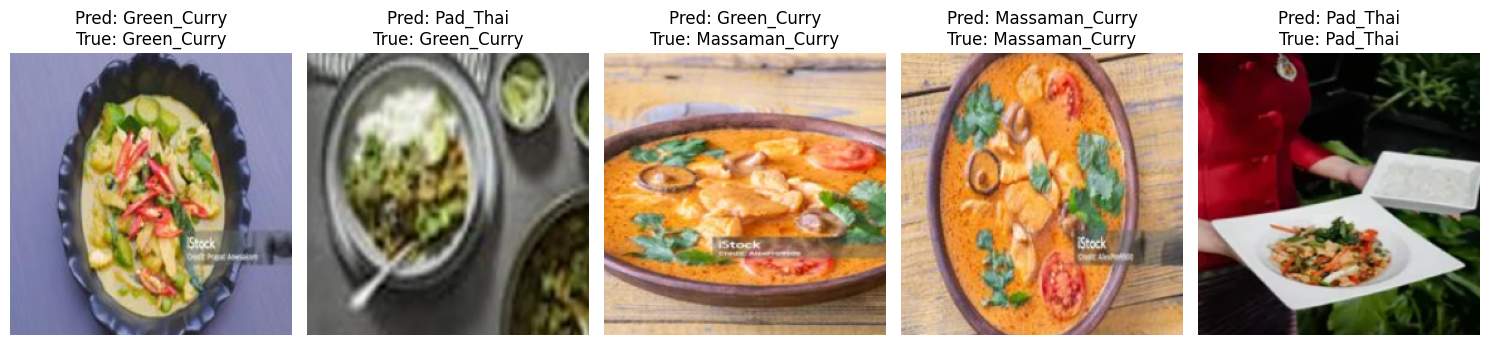

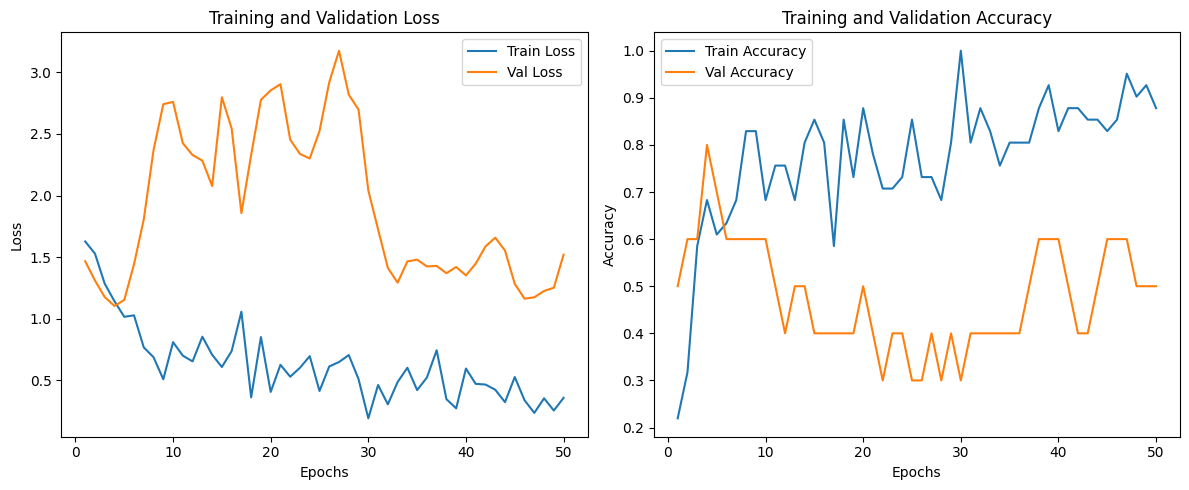

<Figure size 640x480 with 0 Axes>

In [1]:
import os
import random
import shutil
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error

# Paths for dataset
base_dir = '/content/drive/MyDrive/thai_dishes_images'
output_dir = '/content/drive/MyDrive/thai_dishes_split'
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')

# Step 1: Preprocessing Images
def preprocess_images(input_dir, output_dir, size=(224, 224)):
    os.makedirs(output_dir, exist_ok=True)
    for dish in os.listdir(input_dir):
        dish_folder = os.path.join(input_dir, dish)
        if os.path.isdir(dish_folder):
            target_folder = os.path.join(output_dir, dish)
            os.makedirs(target_folder, exist_ok=True)
            for image_file in os.listdir(dish_folder):
                img_path = os.path.join(dish_folder, image_file)
                try:
                    with Image.open(img_path) as img:
                        img = img.convert("RGB").resize(size)
                        img.save(os.path.join(target_folder, image_file))
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

# Step 2: Train-Test Split
def split_dataset(input_dir, train_dir, test_dir, num_test_images=2):
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    for dish in os.listdir(input_dir):
        dish_folder = os.path.join(input_dir, dish)
        if os.path.isdir(dish_folder):
            all_images = os.listdir(dish_folder)
            random.shuffle(all_images)
            test_images = all_images[:num_test_images]
            train_images = all_images[num_test_images:]

            os.makedirs(os.path.join(train_dir, dish), exist_ok=True)
            os.makedirs(os.path.join(test_dir, dish), exist_ok=True)

            for img in test_images:
                shutil.copy(os.path.join(dish_folder, img), os.path.join(test_dir, dish, img))
            for img in train_images:
                shutil.copy(os.path.join(dish_folder, img), os.path.join(train_dir, dish, img))

preprocessed_dir = '/content/drive/MyDrive/thai_dishes_processed'
preprocess_images(base_dir, preprocessed_dir)
split_dataset(preprocessed_dir, train_dir, test_dir)

# Step 3: Create Data Loaders with Enhanced Augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Random crop and resize
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(15),  # Random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
    transforms.RandomAffine(30),  # Random affine transformations
    transforms.RandomVerticalFlip(),  # Random vertical flip
    transforms.RandomGrayscale(p=0.2),  # Random grayscale with 20% probability
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),  # Only center crop for validation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=val_transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

# Step 4: Train the Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load EfficientNet-B0 and modify the output layer
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(train_data.classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Initialize lists to store metrics
all_labels, all_preds = [], []

# Updated training loop with validation
for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_loss, total_correct = 0.0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total_correct += (preds == labels).sum().item()
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(total_correct / len(train_data))

    # Validation phase
    model.eval()
    val_loss, val_correct = 0.0, 0
    epoch_labels, epoch_preds = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            epoch_labels.extend(labels.cpu().numpy())
            epoch_preds.extend(preds.cpu().numpy())
    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(val_correct / len(test_data))

    # Print metrics for this epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

# Step 5: Calculate Metrics at the End of All Epochs

# Calculate final metrics
accuracy = accuracy_score(epoch_labels, epoch_preds)
f1 = f1_score(epoch_labels, epoch_preds, average='weighted')
conf_matrix = confusion_matrix(epoch_labels, epoch_preds)
mae = mean_absolute_error(epoch_labels, epoch_preds)

# Print metrics after all epochs
print(f"Final Accuracy: {accuracy:.4f}")
print(f"Final F1 Score: {f1:.4f}")
print(f"Final Confusion Matrix:\n{conf_matrix}")
print(f"Final Mean Absolute Error: {mae:.4f}")

# Step 6: Visual Validation
model.eval()
def visualize_predictions(loader, num_images=5):
    model.eval()
    plt.figure(figsize=(15, 10))
    count = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for i in range(images.size(0)):
                if count >= num_images:
                    break
                count += 1
                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
                img = np.clip(img, 0, 1)
                plt.subplot(1, num_images, count)
                plt.imshow(img)
                plt.title(f"Pred: {train_data.classes[preds[i]]}\nTrue: {train_data.classes[labels[i]]}")
                plt.axis('off')
            if count >= num_images:
                break
    plt.tight_layout()
    plt.show()

visualize_predictions(test_loader)

# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/thai_dishes_model_efficientnet.pth')

# Plot training and validation metrics
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
plt.savefig('/content/drive/MyDrive/training_validation_plots.png')
